#### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from dtw import dtw # dynamic timewarping from dtw-python package

from scipy.interpolate import interp1d # for time interpolation

from Sports2D import Sports2D

# importing custom plotting functions
from plotting_functions import plot_joint_angle, plot_all_joints, plot_hip_trajectory

from utilities import list_filepaths, load_multiple_files, compare_joint_angles, compare_aggregated_joint_angles

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



#### Analysing the video's

In [2]:
# Set this to true if you need to re-analyse the videos :)
run_sports2d_analysis = False

In [3]:
import os
from Sports2D import Sports2D

# Define paths relative to the current script/notebook directory
script_dir = os.getcwd()

video_dir = os.path.normpath(os.path.join(script_dir, "../Videos to Analyze/Backflip")) # switch to /Start Salto
config_path = os.path.normpath(os.path.join(script_dir, "../Configs/backflip_config.toml")) # still need to manually move analyzed videos and data to their respective folders (or change it in config)
data_dir = os.path.normpath(os.path.join(script_dir, "../Analyzed Data"))

# Specific move directories
st_salto_data_dir = os.path.normpath(os.path.join(data_dir, "../Analyzed Data/Start Salto"))
backflip_data_dir = os.path.normpath(os.path.join(data_dir, "../Analyzed Data/Backflip"))


# Get a list of all video files in the directory
video_files = list_filepaths(video_dir, [".mp4", ".mov"])

# Load the configuration file
config = Sports2D.read_config_file(config_path)


In [4]:
# Update the video input in the config and process each video

if run_sports2d_analysis == True:
    for video_file in video_files:
        try:
            config['project']['video_input'] = [video_file]
            Sports2D.process(config)
        except Exception as e:
            print(f"Error processing video {video_file}: {e}")

#### Loading Data

In [5]:
# get file paths contained in analyzed video data
backflip_trc_file_paths = list_filepaths(backflip_data_dir, '.trc')
backflip_mot_file_paths = list_filepaths(backflip_data_dir, '.mot')

#print(backflip_trc_file_paths)

# create combined dataframes of them
backflip_trc_combined_df = load_multiple_files(backflip_trc_file_paths, file_type='trc')
backflip_mot_combined_df = load_multiple_files(backflip_mot_file_paths, file_type='mot')

For filepath: /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Backflip/id1_2_baseline_Sports2D/id1_2_baseline_Sports2D_px_person00.trc, Match status: <re.Match object; span=(161, 205), match='Sports2D/id1_2_baseline_Sports2D_px_person00'>
For filepath: /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Backflip/id1_3_pettlep_Sports2D/id1_3_pettlep_Sports2D_px_person00.trc, Match status: <re.Match object; span=(160, 203), match='Sports2D/id1_3_pettlep_Sports2D_px_person00'>
For filepath: /Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Analyzed Data/Backflip/id1_1_baseline_Sports2D/id1_1_baseline_Sports2D_px_person00.trc, Match status: <re.Match object; span=(161, 205), match='Sports2D/id1_1_baseline_Sports2D_px_person00'>
For filepath: /User

#### Combine into 1 dataframe

In [6]:
# join trc and mot
# Ensure consistent column naming
backflip_trc_combined_df = backflip_trc_combined_df.rename(columns={"Time": "time"})

# Perform the merge
merged_df = pd.merge(
    backflip_trc_combined_df,
    backflip_mot_combined_df,
    on=["time", "participant_id", "video_number", "condition", "person_tracked"],
    how="inner"  # Only include rows with matching keys
)

# Optional: Drop redundant columns from `mot` DataFrame
merged_df = merged_df.drop(columns=["version", "nRows", "nColumns", "inDegrees"], errors="ignore")

# Check the results
print(f"Shape of merged DataFrame: {merged_df.shape}")
print(f"Columns in merged DataFrame: {merged_df.columns.tolist()}")
print(f"Unique participants: {merged_df['participant_id'].nunique()}")
print(f"Unique video numbers: {merged_df['video_number'].nunique()}")
print(f"Unique conditions: {merged_df['condition'].nunique()}")

Shape of merged DataFrame: (1210, 95)
Columns in merged DataFrame: ['Frame#', 'time', 'Hip_X', 'Hip_Y', 'Hip_Z', 'RHip_X', 'RHip_Y', 'RHip_Z', 'RKnee_X', 'RKnee_Y', 'RKnee_Z', 'RAnkle_X', 'RAnkle_Y', 'RAnkle_Z', 'RBigToe_X', 'RBigToe_Y', 'RBigToe_Z', 'RSmallToe_X', 'RSmallToe_Y', 'RSmallToe_Z', 'RHeel_X', 'RHeel_Y', 'RHeel_Z', 'LHip_X', 'LHip_Y', 'LHip_Z', 'LKnee_X', 'LKnee_Y', 'LKnee_Z', 'LAnkle_X', 'LAnkle_Y', 'LAnkle_Z', 'LBigToe_X', 'LBigToe_Y', 'LBigToe_Z', 'LSmallToe_X', 'LSmallToe_Y', 'LSmallToe_Z', 'LHeel_X', 'LHeel_Y', 'LHeel_Z', 'Neck_X', 'Neck_Y', 'Neck_Z', 'Head_X', 'Head_Y', 'Head_Z', 'Nose_X', 'Nose_Y', 'Nose_Z', 'RShoulder_X', 'RShoulder_Y', 'RShoulder_Z', 'RElbow_X', 'RElbow_Y', 'RElbow_Z', 'RWrist_X', 'RWrist_Y', 'RWrist_Z', 'LShoulder_X', 'LShoulder_Y', 'LShoulder_Z', 'LElbow_X', 'LElbow_Y', 'LElbow_Z', 'LWrist_X', 'LWrist_Y', 'LWrist_Z', 'participant_id', 'video_number', 'condition', 'person_tracked', 'right_knee', 'left_knee', 'left_ankle', 'right_ankle', 'left_hip'

## Determining and Removing "Depth" axis from the data

We are relying on the fact that the depth will remain mostly constant, so we remove the axis with the least variance in the data assuming this to be the depth axis

In [7]:
# Step 1: Identify remaining axes in the DataFrame
coordinate_cols = [col for col in merged_df.columns if any(col.endswith(axis) for axis in ["_X", "_Y", "_Z"])]
joint_names = set(col.rsplit('_', 1)[0] for col in coordinate_cols)  # Extract unique joint names
remaining_axes = {"X", "Y", "Z"} & set(axis[-1] for axis in coordinate_cols if axis[-2:] in {"_X", "_Y", "_Z"})

# Calculate variance only for the remaining axes
variance_results = {axis: 0 for axis in remaining_axes}
for axis in remaining_axes:
    axis_cols = [f"{joint}_{axis}" for joint in joint_names if f"{joint}_{axis}" in merged_df.columns]
    if axis_cols:  # Only calculate if columns exist
        variance_results[axis] = merged_df[axis_cols].var().mean()

# Determine the depth axis if multiple remain
if len(variance_results) > 2:
    depth_axis = min(variance_results, key=variance_results.get)
    print(f"Depth axis identified as: {depth_axis}")

    # Step 2: Remove depth coordinate columns if they exist
    depth_cols = [f"{joint}_{depth_axis}" for joint in joint_names if f"{joint}_{depth_axis}" in merged_df.columns]
    merged_df = merged_df.drop(columns=depth_cols, errors="ignore")
    print(f"Columns removed: {depth_cols}")
else:
    print(f"Depth axis removal skipped. Remaining axes: {remaining_axes}")


Depth axis identified as: Z
Columns removed: ['Nose_Z', 'RWrist_Z', 'Head_Z', 'LAnkle_Z', 'LWrist_Z', 'RHip_Z', 'RElbow_Z', 'Hip_Z', 'RAnkle_Z', 'LKnee_Z', 'LHeel_Z', 'LBigToe_Z', 'RHeel_Z', 'RKnee_Z', 'LElbow_Z', 'RBigToe_Z', 'RSmallToe_Z', 'LSmallToe_Z', 'RShoulder_Z', 'LShoulder_Z', 'Neck_Z', 'LHip_Z']


## Adding Derived Metrics for Fun
**Joint velocity:** How quickly the joint moves (in coordinates)

**Angular Velocity:** How quickly the angle changes (in degrees)

In [8]:
# Step 3: Calculate Joint Velocity (without depth)
for joint in joint_names:
    # Calculate velocity components (X, Y)
    for axis in ["X", "Y"]:  # Only remaining axes
        col_name = f"{joint}_{axis}"
        merged_df[f"{joint}_vel_{axis}"] = merged_df[col_name].diff() / merged_df["time"].diff()

    # Calculate the magnitude of velocity
    velocity_components = [merged_df[f"{joint}_vel_{axis}"] for axis in ["X", "Y"]]
    merged_df[f"{joint}_velocity"] = np.sqrt(sum(comp**2 for comp in velocity_components))

# Step 4: Angular Velocity Calculation
# Identify angular columns (e.g., `right_knee`, `left_knee`, etc.)
angular_cols = [col for col in merged_df.columns if col in ["right_knee", "left_knee", "left_ankle", "right_ankle"]]
for col in angular_cols:
    merged_df[f"{col}_ang_vel"] = merged_df[col].diff() / merged_df["time"].diff()

# Step 5: Handle NaN Values (first row in each group has NaN for velocity due to diff())
merged_df = merged_df.fillna(0)

# Verify the updated DataFrame
print(f"Columns after depth removal and velocity calculation: {merged_df.columns}")

Columns after depth removal and velocity calculation: Index(['Frame#', 'time', 'Hip_X', 'Hip_Y', 'RHip_X', 'RHip_Y', 'RKnee_X',
       'RKnee_Y', 'RAnkle_X', 'RAnkle_Y',
       ...
       'Neck_vel_X', 'Neck_vel_Y', 'Neck_velocity', 'LHip_vel_X', 'LHip_vel_Y',
       'LHip_velocity', 'right_knee_ang_vel', 'left_knee_ang_vel',
       'left_ankle_ang_vel', 'right_ankle_ang_vel'],
      dtype='object', length=143)


## Calculating Summary Statistics for ANCOVA

In [9]:
# Calculate peak hip height for baseline and backflip trials
summary_df = merged_df.groupby(["participant_id", "condition"]).agg({
    "Hip_Y": "max"  # Assuming 'Hip_Y' represents vertical hip height
}).reset_index()

# Rename for clarity
summary_df = summary_df.rename(columns={"Hip_Y": "peak_hip_height"})

In [10]:
# Split baseline and backflip peak hip heights
summary_df["baseline_peak_hip_height"] = summary_df.apply(
    lambda row: row["peak_hip_height"] if row["condition"] == "baseline" else None, axis=1
)
summary_df["backflip_peak_hip_height"] = summary_df.apply(
    lambda row: row["peak_hip_height"] if row["condition"] in ["pure", "pettlep"] else None, axis=1
)

# Fill baseline for each participant
summary_df["baseline_peak_hip_height"] = summary_df.groupby("participant_id")["baseline_peak_hip_height"].transform("first")


In [11]:
# Keep only rows for the experimental conditions
ancova_df = summary_df[summary_df["condition"].isin(["pure", "pettlep"])]

In [12]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit ANCOVA model
model = ols(
    "backflip_peak_hip_height ~ baseline_peak_hip_height + condition", data=ancova_df
).fit()

# Output results
print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     backflip_peak_hip_height   R-squared:                       1.000
Model:                                  OLS   Adj. R-squared:                    nan
Method:                       Least Squares   F-statistic:                       nan
Date:                      Mon, 02 Dec 2024   Prob (F-statistic):                nan
Time:                              12:54:53   Log-Likelihood:                 71.106
No. Observations:                         2   AIC:                            -138.2
Df Residuals:                             0   BIC:                            -140.8
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

/Users/niels/miniconda3/envs/GymSports2D/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/Users/niels/miniconda3/envs/GymSports2D/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/niels/miniconda3/envs/GymSports2D/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/Users/niels/miniconda3/envs/GymSports2D/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


## Simulating more data from my own videos to test ANCOVA properly

In [13]:
import numpy as np
import pandas as pd

# Simulate splitting data into 8 participants (4 per group)
def simulate_data_with_noise(df, num_splits=4, noise_sd=0.05):
    # Repeat rows to create artificial participants
    simulated_df = df.loc[df.index.repeat(num_splits)].reset_index(drop=True)

    # Add random noise to create variability
    np.random.seed(42)  # For reproducibility
    simulated_df["backflip_peak_hip_height"] += np.random.normal(
        loc=0, scale=noise_sd, size=len(simulated_df)
    )
    simulated_df["baseline_peak_hip_height"] += np.random.normal(
        loc=0, scale=noise_sd, size=len(simulated_df)
    )

    # Assign new participant IDs
    simulated_df["participant_id"] = (
        simulated_df.groupby(["condition"]).cumcount() % num_splits + 1
    ).astype(str)
    simulated_df["participant_id"] = (
        simulated_df["condition"] + "_participant_" + simulated_df["participant_id"]
    )

    return simulated_df

# Simulate data with noise
simulated_ancova_df = simulate_data_with_noise(ancova_df, num_splits=4, noise_sd=0.1)

# Verify simulated data
print(simulated_ancova_df.head())


          participant_id condition  peak_hip_height  baseline_peak_hip_height  \
0  pettlep_participant_1   pettlep        -0.284826                 -0.368587   
1  pettlep_participant_2   pettlep        -0.284826                 -0.267384   
2  pettlep_participant_3   pettlep        -0.284826                 -0.367982   
3  pettlep_participant_4   pettlep        -0.284826                 -0.368213   
4     pure_participant_1      pure        -0.284424                 -0.257545   

   backflip_peak_hip_height  
0                 -0.235155  
1                 -0.298653  
2                 -0.220058  
3                 -0.132523  
4                 -0.307839  


In [14]:
# Fit ANCOVA model
model = ols(
    "backflip_peak_hip_height ~ baseline_peak_hip_height + condition", data=simulated_ancova_df
).fit()

# Output results
print(model.summary())


                               OLS Regression Results                               
Dep. Variable:     backflip_peak_hip_height   R-squared:                       0.208
Model:                                  OLS   Adj. R-squared:                 -0.109
Method:                       Least Squares   F-statistic:                    0.6569
Date:                      Mon, 02 Dec 2024   Prob (F-statistic):              0.558
Time:                              12:54:53   Log-Likelihood:                 11.015
No. Observations:                         8   AIC:                            -16.03
Df Residuals:                             5   BIC:                            -15.79
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

/Users/niels/miniconda3/envs/GymSports2D/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


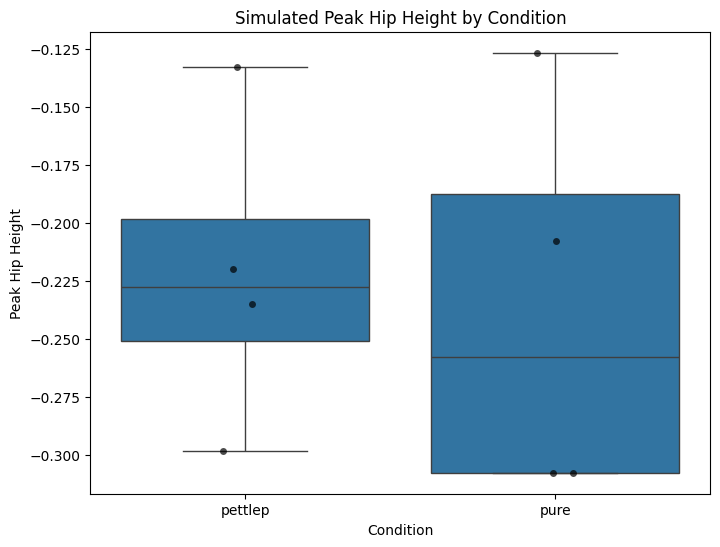

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(data=simulated_ancova_df, x="condition", y="backflip_peak_hip_height")
sns.stripplot(
    data=simulated_ancova_df, x="condition", y="backflip_peak_hip_height", color="black", alpha=0.7, jitter=True
)
plt.title("Simulated Peak Hip Height by Condition")
plt.ylabel("Peak Hip Height")
plt.xlabel("Condition")
plt.show()


# Scoring the backflips
We will use the Execution criteria of assessment provided by the "IMMEDIATE EFFECT..."-paper.

This means that we have the following stats:

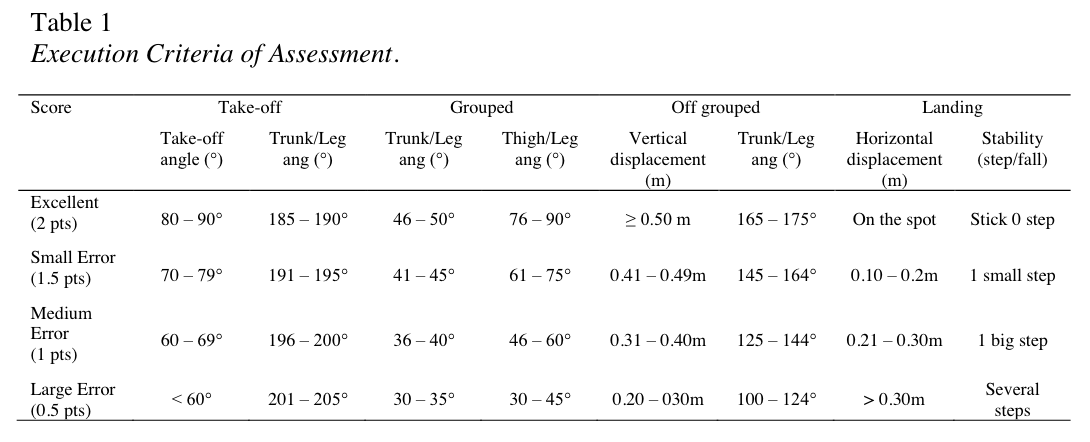

It therefore also means that we need to figure out how to define and detect these things computationally:
Take-Off Angle: TRUNK-SEGMENT-value(angle), When foot's leave the ground

In [16]:
print(merged_df.columns[0:70])

Index(['Frame#', 'time', 'Hip_X', 'Hip_Y', 'RHip_X', 'RHip_Y', 'RKnee_X',
       'RKnee_Y', 'RAnkle_X', 'RAnkle_Y', 'RBigToe_X', 'RBigToe_Y',
       'RSmallToe_X', 'RSmallToe_Y', 'RHeel_X', 'RHeel_Y', 'LHip_X', 'LHip_Y',
       'LKnee_X', 'LKnee_Y', 'LAnkle_X', 'LAnkle_Y', 'LBigToe_X', 'LBigToe_Y',
       'LSmallToe_X', 'LSmallToe_Y', 'LHeel_X', 'LHeel_Y', 'Neck_X', 'Neck_Y',
       'Head_X', 'Head_Y', 'Nose_X', 'Nose_Y', 'RShoulder_X', 'RShoulder_Y',
       'RElbow_X', 'RElbow_Y', 'RWrist_X', 'RWrist_Y', 'LShoulder_X',
       'LShoulder_Y', 'LElbow_X', 'LElbow_Y', 'LWrist_X', 'LWrist_Y',
       'participant_id', 'video_number', 'condition', 'person_tracked',
       'right_knee', 'left_knee', 'left_ankle', 'right_ankle', 'left_hip',
       'right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow',
       'right_foot', 'left_foot', 'right_shank', 'left_shank', 'right_thigh',
       'left_thigh', 'pelvis', 'trunk', 'shoulders', 'head', 'right_arm'],
      dtype='object')


In [17]:

import matplotlib.pyplot as plt
import pandas as pd

def plot_joint_trajectory(
    df,
    joint_name,
    participants=None,
    mean_only=False,
    condition=None,
    title="2D Joint Trajectory",
    x_label="X Coordinate",
    y_label="Y Coordinate",
):
    """
    Plots the 2D trajectory of a given joint for specified participants or their mean.

    Parameters:
    df (pd.DataFrame): DataFrame containing the trajectory data.
    joint_name (str): The name of the joint (e.g., "Hip").
    participants (list, optional): List of participant IDs to include. If None, includes all participants.
    mean_only (bool, optional): Whether to plot only the mean trajectory. Defaults to False.
    condition (str, optional): Filter by condition (e.g., "pure" or "pettlep"). Defaults to None.
    title (str, optional): Title of the plot.
    x_label (str, optional): Label for the x-axis.
    y_label (str, optional): Label for the y-axis.

    Returns:
    None: Displays the plot.
    """
    # Filter participants if specified
    if participants:
        df = df[df["participant_id"].isin(participants)]

    # Filter condition if specified
    if condition:
        df = df[df["condition"] == condition]

    # Extract joint data
    x_col = f"{joint_name}_X"
    y_col = f"{joint_name}_Y"

    if mean_only:
        # Plot mean trajectory
        mean_df = df.groupby("time")[[x_col, y_col]].mean()
        plt.plot(mean_df[x_col], mean_df[y_col], label="Mean Trajectory", linewidth=2)
    else:
        # Plot each participant separately
        for participant, group in df.groupby("participant_id"):
            plt.plot(group[x_col], group[y_col], label=f"Participant {participant}", alpha=0.7)

    # Plot formatting
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()



#### Single Participant Trajectory

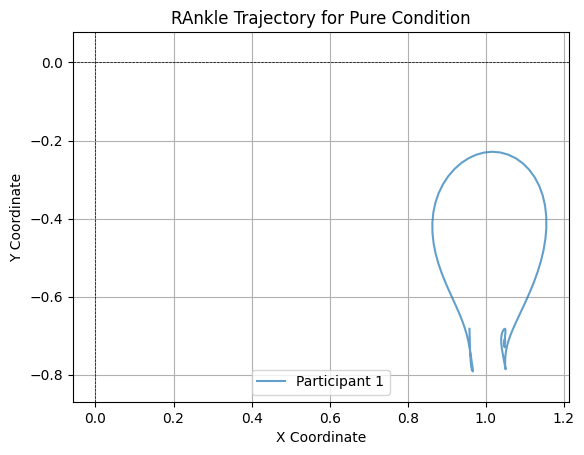

In [18]:
joint_to_plot = "RAnkle"

plot_joint_trajectory(
    df=merged_df,
    joint_name=joint_to_plot,
    participants=["1", "2"],  # Replace with actual participant IDs
    condition="pettlep",
    title=f"{joint_to_plot} Trajectory for Pure Condition",
)


#### Mean Trajectory Only

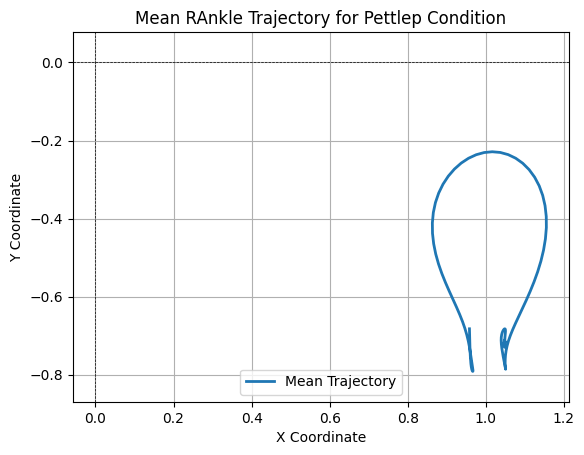

In [19]:
plot_joint_trajectory(
    df=merged_df,
    joint_name=joint_to_plot,
    mean_only=True,
    condition="pettlep",
    title=f"Mean {joint_to_plot} Trajectory for Pettlep Condition",
)


#### All participants (default)

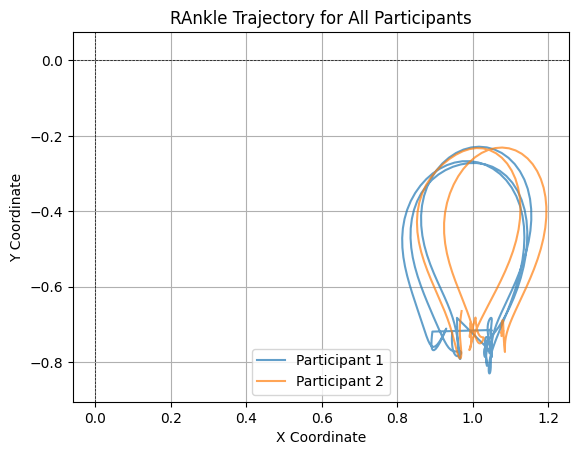

In [20]:
plot_joint_trajectory(
    df=merged_df,
    joint_name=joint_to_plot,
    title=f"{joint_to_plot} Trajectory for All Participants",
)


# Overlay trajectory on video

In [21]:
video_path = "/Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Videos to Analyze/Backflip/id1_1_baseline.mov"
output_path = "/Users/niels/Desktop/University/Third Semester/Perception and Action/Exam/Gymnastics Motion Tracking/Code for Gym Tracking/Overlay Videos/overlay_video_id1_1_baseline.mp4"

print(merged_df["participant_id"].unique(), merged_df["participant_id"].dtype)
print(merged_df["video_number"].unique(), merged_df["video_number"].dtype)
print(merged_df["condition"].unique(), merged_df["condition"].dtype)


df_id1_1_baseline = merged_df[(merged_df["participant_id"] == '1') & (merged_df["video_number"] == '1') & (merged_df["condition"] == 'baseline')]

print(df_id1_1_baseline.head())

['1' '2'] object
['2' '3' '1'] object
['baseline' 'pettlep' 'pure'] object
     Frame#      time     Hip_X     Hip_Y    RHip_X    RHip_Y   RKnee_X  \
476       0  0.000000  1.063977 -0.572193  1.057893 -0.569117  1.051768   
477       1  0.016661  1.063810 -0.572225  1.058033 -0.569331  1.051875   
478       2  0.033322  1.063665 -0.572261  1.058184 -0.569564  1.051988   
479       3  0.049983  1.063558 -0.572302  1.058349 -0.569830  1.052112   
480       4  0.066643  1.063492 -0.572350  1.058532 -0.570140  1.052250   

      RKnee_Y  RAnkle_X  RAnkle_Y  ...  Neck_vel_X  Neck_vel_Y  Neck_velocity  \
476 -0.671606  1.033442 -0.757230  ...   -0.041995    0.013327       0.044059   
477 -0.671508  1.033483 -0.757540  ...   -0.012491   -0.018481       0.022306   
478 -0.671428  1.033498 -0.757832  ...   -0.011106   -0.015052       0.018705   
479 -0.671375  1.033473 -0.758092  ...   -0.008797   -0.009440       0.012903   
480 -0.671358  1.033399 -0.758314  ...   -0.006083   -0.002506       